In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_list = []

file_in = "raw_data/wells"

for i in range(1,62):
    a = str(i)
    temp = pd.read_excel(file_in + a + ".xlsx")
    df_list.append(temp)
    
df = pd.concat(df_list)


In [3]:
df = df.drop_duplicates()

In [4]:
df.isna().sum()

Registry No. (55-)         0
GWSI Site ID           18810
Cadastral                  0
Owner Name                68
Well Type                  0
Well Depth (ft)         2482
Casing Depth (ft)       2680
Case Dia (in)           2618
Drill Date              6757
Applicaiton Date          32
Water Level (ft)        2983
Pump Capacity (GPM)     6851
Pump Data Available        0
Completion Report      15998
Log Received           12396
dtype: int64

In [5]:
df.dtypes

Registry No. (55-)              int64
GWSI Site ID                  float64
Cadastral                      object
Owner Name                     object
Well Type                      object
Well Depth (ft)               float64
Casing Depth (ft)             float64
Case Dia (in)                 float64
Drill Date                     object
Applicaiton Date       datetime64[ns]
Water Level (ft)              float64
Pump Capacity (GPM)           float64
Pump Data Available            object
Completion Report              object
Log Received                   object
dtype: object

In [6]:
df = df.dropna(subset=['Well Depth (ft)'])
df = df.dropna(subset=['Drill Date'])

# we shouldn't have well depth or water level of 0. In fact, let's drop everything less than 20 ft.
df = df.loc[df['Well Depth (ft)'] != 0]
df = df.loc[df['Well Depth (ft)'] >= 20]

df = df.loc[df['Water Level (ft)'] != 0]
df = df.loc[df['Water Level (ft)'] >= 20]

In [7]:
# Change Drill Date column to datetime type
df['Drill Date'] = pd.to_datetime(df['Drill Date'], errors = 'coerce')

# Create new column to express the year drilled:
df['Year'] = df['Drill Date'].dt.year
    

In [8]:
df.head()

,Registry No. (55-),GWSI Site ID,Cadastral,Owner Name,Well Type,Well Depth (ft),Casing Depth (ft),Case Dia (in),Drill Date,Applicaiton Date,Water Level (ft),Pump Capacity (GPM),Pump Data Available,Completion Report,Log Received,Year
0,87026,NaN,D14031010CAB,"KRACHE, DENNIS,",NON-EXEMPT,85.0,85.0,16.0,1981-01-01,1997-09-24,40.0,0.0,NO,NaN,NaN,1981.0
1,204440,NaN,D13031030CCC,ARIZONA DEPARTMENT OF ENVIRONMENTAL QUALITY,MONITOR,80.0,80.0,2.0,2004-07-28,2004-07-21,55.0,NaN,NO,NaN,X,2004.0
2,209499,NaN,D14031004AAD,FICO SS FARMS LLC,NON-EXEMPT,1011.0,1011.0,12.0,2006-06-19,2005-09-30,335.0,NaN,NO,NaN,X,2006.0
3,211737,NaN,D13031029AAC,BRIAN & GERILINE DRISCOLL,NON-EXEMPT,740.0,740.0,6.0,2007-02-07,2006-04-10,90.0,200.0,NO,X,X,2007.0
4,220279,3.214101e+14,D14031010ABA,FORT BOWIE RANCHES,EXEMPT,540.0,540.0,8.0,2011-01-23,2010-12-09,160.0,NaN,NO,NaN,X,2011.0


In [9]:
df1960 = df[df['Year'] >= 1960]

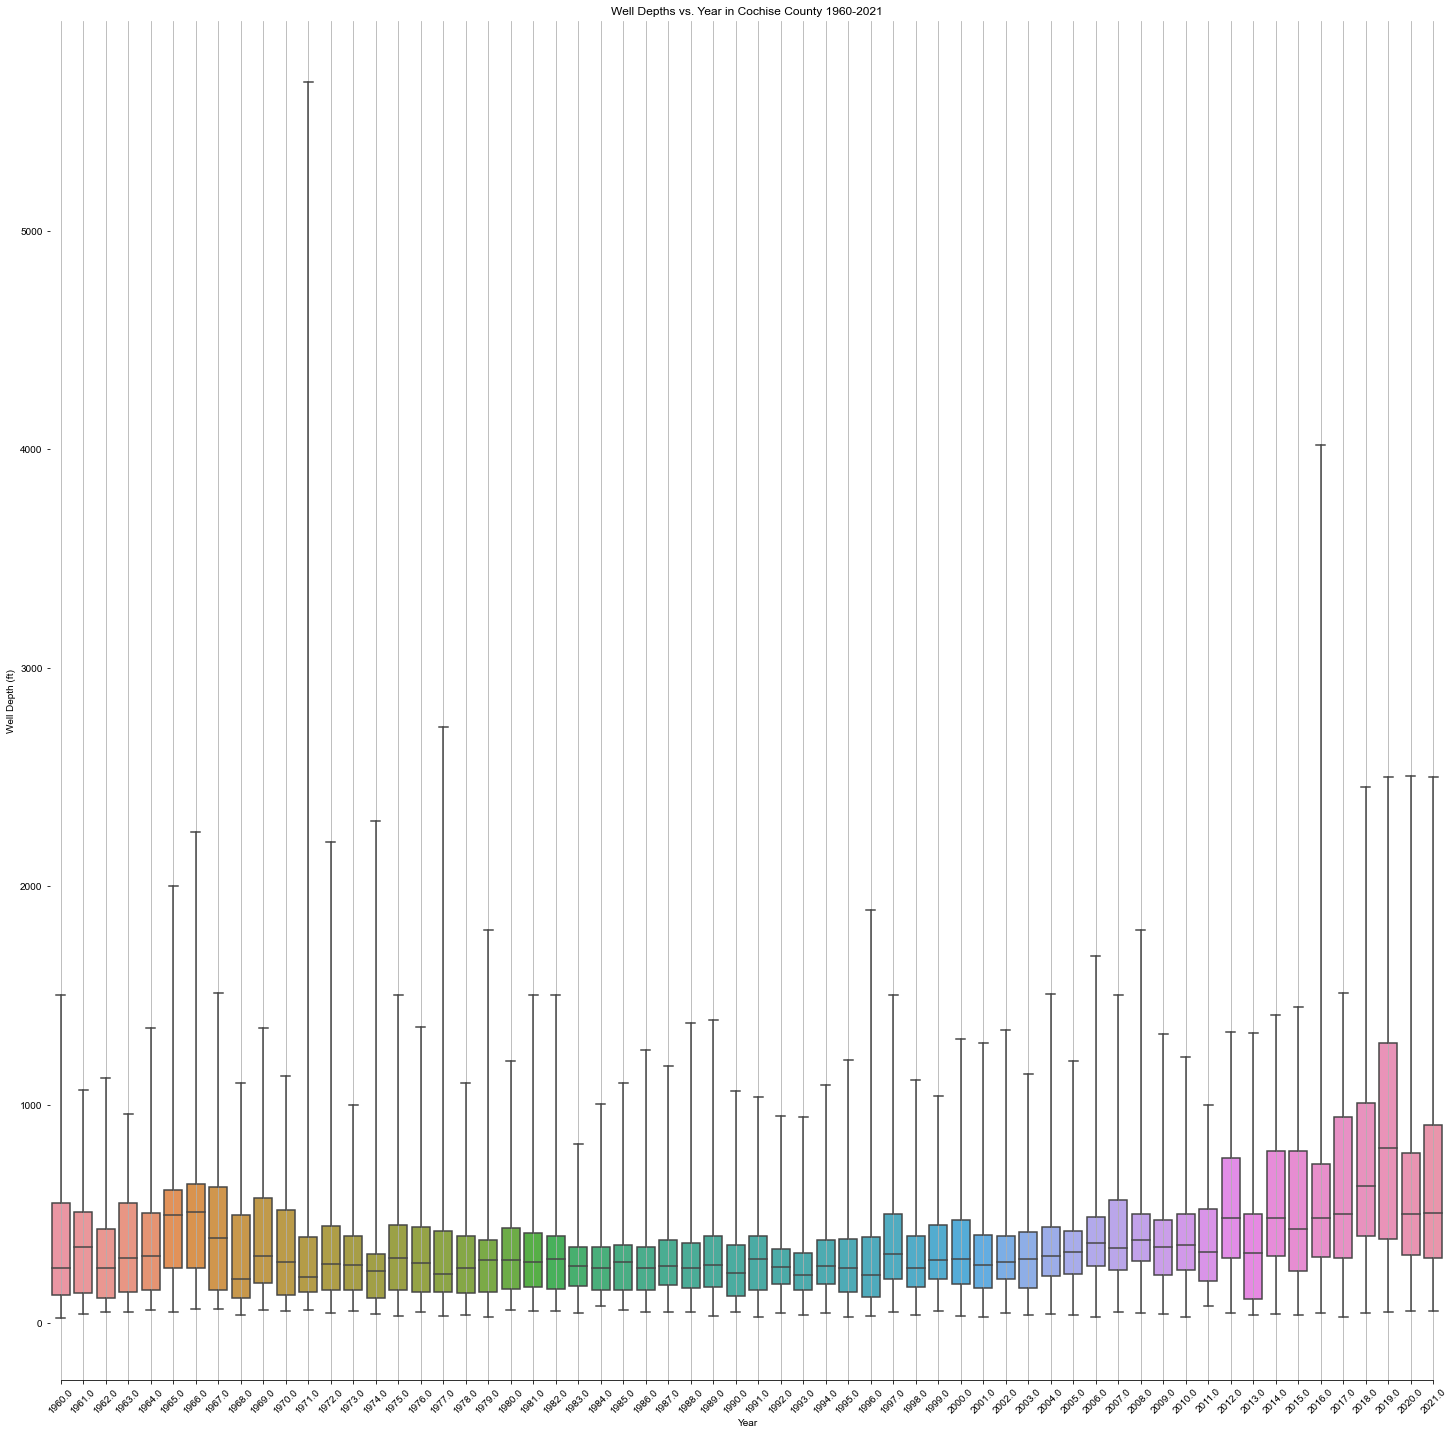

In [10]:
fig, ax = plt.subplots(figsize=(25,25))

sns.boxplot(x=df1960['Year'], y=df1960['Well Depth (ft)'], data=df1960, whis=[0,100])
ax.set_title("Well Depths vs. Year in Cochise County 1960-2021")
ax.set_ylabel("Well Depth (ft)")
ax.set_xlabel("Year")
sns.set(font_scale=1)
ax.xaxis.grid(True)
plt.xticks(rotation=45)
sns.despine(trim=True, left=True)

plt.show()

Next Steps:

--> I would like to see a graph of the averages or medians over time (maybe since 1960?)
--> Graph of the 75 percentile over time

Fundamentals or other news events that can tie in here? Is there any lifting of regulations, etc that occured between 1960 and today?

Other notes/to explore:
It's interesting that the max values for years 2019-2021 look identical. Has there been a max well depth regulation put in place? What is the reasoning behind this?

There are a lot of wells that are close to zero still. This can't be accurate -- We should find the true minimum, based on the water levels? What is the average water level for Cochise county, then make that-100ft the min? 

In [11]:
# Lets find the average water level in Cochise County:

df["Water Level (ft)"].describe()

count    12911.000000
mean       182.650298
std        167.240631
min         20.000000
25%         70.000000
50%        140.000000
75%        250.000000
max       5505.000000
Name: Water Level (ft), dtype: float64

<AxesSubplot:>

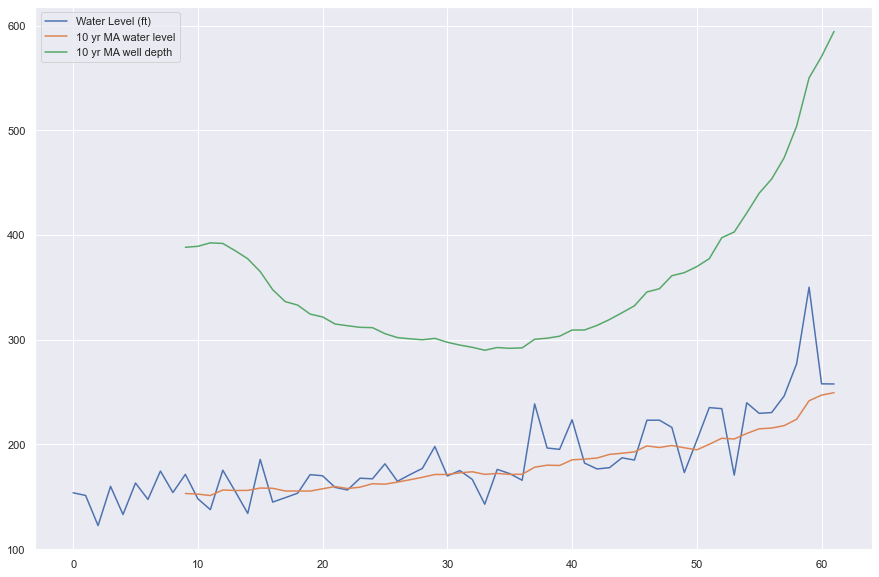

In [12]:
mean_waterlvl = df1960.groupby(['Year']).mean().reset_index()
mean_waterlvl.set_index('Year')

mean_waterlvl['10 yr MA water level'] = mean_waterlvl['Water Level (ft)'].rolling(10).mean()

mean_waterlvl['10 yr MA well depth'] = mean_waterlvl['Well Depth (ft)'].rolling(10).mean()

# why does it distort my plot when i try to add these as xticks?
xi = np.linspace(1960,2020,61)

mean_waterlvl[['Water Level (ft)', '10 yr MA water level', '10 yr MA well depth']].plot(figsize = (15,10))



Given the above chart, we see an increasing difference between the average water level and the well depth. This could be observered as anticipatory 

Between 1970 and 1995-ish, the 10 year moving average well depth was decreasing. Why? Were people not worried about running out of water? Trying to save money on well drilling? 

Starting 2010, well depth skyrocketed while the water level was only getting slightly deeper.


NEXT STEPS:
 
--> Compare the slopes or derivatives of each Moving Average.
    --> what's the difference between the derivatives, and what does this imply? 
    
Maybe we should look for more data, like # large farms in cochise county? 
    --> Looked into this, data is only published every 5 years and the last was 2017... 
        --> may or may not still be helpful?

In [13]:
# Who owns the most wells?

df_owners = df1960['Owner Name'].value_counts()
df_owners = df_owners.loc[df_owners >= 10]

df_owners

  ARIZONA DEPARTMENT OF ENVIRONMENTAL QUALITY                     132
 AZ STATE LAND DEPT,                                              114
  RIVERVIEW LLP DBA CORONADO FARMS LLP                             71
  CONOCO PHILLIPS COMPANY                                          61
 PHELPS DODGE CORP,                                                55
  RIVERVIEW, LLP DBA CORONADO FARMS LLP                            52
  RIVERVIEW LLP                                                    39
  ARIZONA STATE LAND DEPARTMENT                                    34
  RIVERVIEW, LLP                                                   33
  EXCELSIOR MINING CORP                                            33
  EXCELSIOR MINING CORPORATION                                     29
  SHELL OIL PRODUCTS US                                            23
 AZ ELECTRIC POWER,                                                23
  PISTA ORCHARD LLC                                                23
  RIVERVIEW, LLP DBA

In [14]:
# How about well owners with the name riverview?
# counted manually, 238 wells belong to riverview.

In [17]:
df_rv = df1960['Owner Name'].str.contains('riverview')

KeyError: 'Owner Name'

Series([], Name: Owner Name, dtype: object)